In [58]:
import pandas as pd
import numpy as np
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip
import matplotlib.pyplot as plt 

datafile='./dataset9/test9.parquet'
# datafile='./dataset9/data9.parquet'

data=pd.read_parquet(datafile)
# Initialize GeoIP databases
gi = pygeoip.GeoIP('./GeoIP_DBs/GeoIP.dat')
gi2 = pygeoip.GeoIP('./GeoIP_DBs/GeoIPASNum.dat')


In [26]:
addr='193.136.713.58'

ip_present = addr in data['src_ip'].values or addr in data['dst_ip'].values

if ip_present:
    # Perform geolocation lookup
    cc = gi.country_code_by_addr(addr)
    org = gi2.org_by_addr(addr)

    print("cc: ", cc, "org: ", org)
else:
    print(f"The IP address {addr} is not present in the dataset.")


The IP address 193.136.713.58 is not present in the dataset.



# Identify the range of internal IP addresses and verify which ones are considered internal devices.

In [27]:
# Define internal IP ranges (assuming IPv4 and internal IPs are in the private ranges)
internal_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']

# Filter data for internal IP addresses
internal_data = data[data['dst_ip'].str.startswith(tuple(internal_ip_ranges))]

# Group by destination IP and port to identify internal servers/services
internal_services = internal_data.groupby(['dst_ip', 'port']).agg({'up_bytes': 'sum', 'down_bytes': 'sum', 'dst_ip': 'count'}).rename(columns={'dst_ip': 'connections'})

# Sort by number of connections to identify most accessed internal servers/services
internal_services_sorted = internal_services.sort_values(by='connections', ascending=False)

print(internal_services_sorted)

                       up_bytes  down_bytes  connections
dst_ip          port                                    
192.168.109.227 443   928490251  8608953582        81417
192.168.109.224 443   917574456  8462169252        80856
192.168.109.230 53     14417249    33138270        72241
192.168.109.225 53     14150672    32511405        70679
192.168.109.61  443      458949      459917          206
192.168.109.31  443      469354      471411          205
192.168.109.126 443      421636      421530          187
192.168.109.168 443      341968      339039          149
192.168.109.14  443      251270      255663          112


# Look for IP addresses that frequently serve traffic and the ports they use (e.g., HTTP on port 80, HTTPS on port 443, DNS on port 53).

In [28]:
# Define the internal IP range prefix
internal_ip_prefix = '192.168.109.'

# Filter data for internal IP addresses
internal_data = data[data['dst_ip'].str.startswith(internal_ip_prefix)]

# Group by destination IP and port to identify internal servers/services
internal_services = internal_data.groupby(['dst_ip', 'port']).agg({'up_bytes': 'sum', 'down_bytes': 'sum', 'dst_ip': 'count'}).rename(columns={'dst_ip': 'connections'})

# Sort by number of connections to identify most accessed internal servers/services
internal_services_sorted = internal_services.sort_values(by='connections', ascending=False)

print(internal_services_sorted)

                       up_bytes  down_bytes  connections
dst_ip          port                                    
192.168.109.227 443   928490251  8608953582        81417
192.168.109.224 443   917574456  8462169252        80856
192.168.109.230 53     14417249    33138270        72241
192.168.109.225 53     14150672    32511405        70679
192.168.109.61  443      458949      459917          206
192.168.109.31  443      469354      471411          205
192.168.109.126 443      421636      421530          187
192.168.109.168 443      341968      339039          149
192.168.109.14  443      251270      255663          112


# Calculate the average upload and download bytes for internal-to-internal traffic flows.


Typical Internal to Internal Traffic Volume (mean):
up_bytes      2.085084e+08
down_bytes    1.904302e+09
dtype: float64


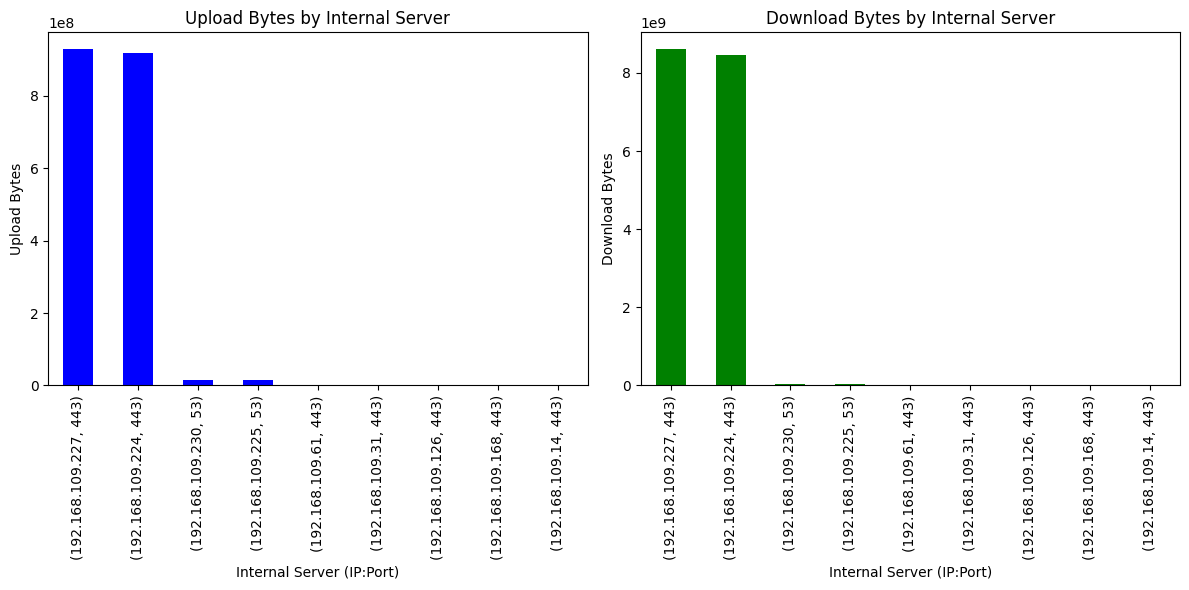

In [29]:
# Calculate typical traffic volume (mean) for internal-to-internal traffic
internal_to_internal_mean = internal_services_sorted[['up_bytes', 'down_bytes']].mean()

print("Typical Internal to Internal Traffic Volume (mean):")
print(internal_to_internal_mean)

# Plot traffic volumes
plt.figure(figsize=(12, 6))

# Upload bytes by server
plt.subplot(1, 2, 1)
internal_services_sorted['up_bytes'].plot(kind='bar', color='blue')
plt.title('Upload Bytes by Internal Server')
plt.xlabel('Internal Server (IP:Port)')
plt.ylabel('Upload Bytes')

# Download bytes by server
plt.subplot(1, 2, 2)
internal_services_sorted['down_bytes'].plot(kind='bar', color='green')
plt.title('Download Bytes by Internal Server')
plt.xlabel('Internal Server (IP:Port)')
plt.ylabel('Download Bytes')

plt.tight_layout()
plt.show()

# Calculate the average upload and download bytes for internal-to-external traffic flows.

Typical External to Public Server Traffic Volume (mean):
up_bytes      3.762933e+07
down_bytes    3.198378e+08
dtype: float64


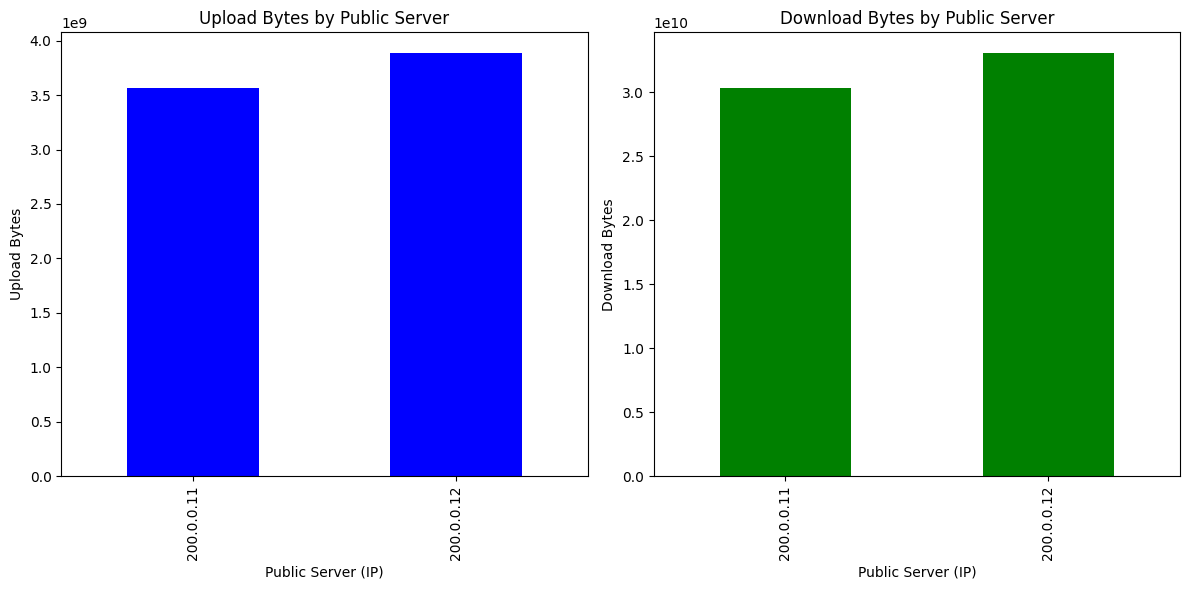

In [30]:
dataserver='./dataset9/servers9.parquet'
dataForServer=pd.read_parquet(dataserver)

# Define the public server IP range prefix (assuming external traffic to 200.0.0.X)
public_server_ip_prefix = '200.0.0.'

# Function to check if an IP is within the public server range
def is_public_server(ip):
    return ip.startswith(public_server_ip_prefix)

# Add a column to classify the destination IP as a public server
dataForServer['dst_public_server'] = dataForServer['dst_ip'].apply(is_public_server)

# Filter data for external-to-public server traffic
external_to_public = data[~dataForServer['src_ip'].str.startswith(internal_ip_prefix) & dataForServer['dst_public_server']]

# Group and aggregate traffic data for external-to-public server traffic
traffic_external_to_public = external_to_public.groupby(['src_ip', 'dst_ip']).agg({'up_bytes': 'sum', 'down_bytes': 'sum'}).reset_index()

# Calculate typical traffic volume (mean) for external-to-public server traffic
typical_external_to_public = traffic_external_to_public[['up_bytes', 'down_bytes']].mean()

print("Typical External to Public Server Traffic Volume (mean):")
print(typical_external_to_public)

# Visualize external-to-public server traffic
plt.figure(figsize=(12, 6))

# Upload bytes by public server
plt.subplot(1, 2, 1)
traffic_external_to_public.groupby('dst_ip')['up_bytes'].sum().plot(kind='bar', color='blue')
plt.title('Upload Bytes by Public Server')
plt.xlabel('Public Server (IP)')
plt.ylabel('Upload Bytes')

# Download bytes by public server
plt.subplot(1, 2, 2)
traffic_external_to_public.groupby('dst_ip')['down_bytes'].sum().plot(kind='bar', color='green')
plt.title('Download Bytes by Public Server')
plt.xlabel('Public Server (IP)')
plt.ylabel('Download Bytes')

plt.tight_layout()
plt.show()


# Code for Comparative Analysis:

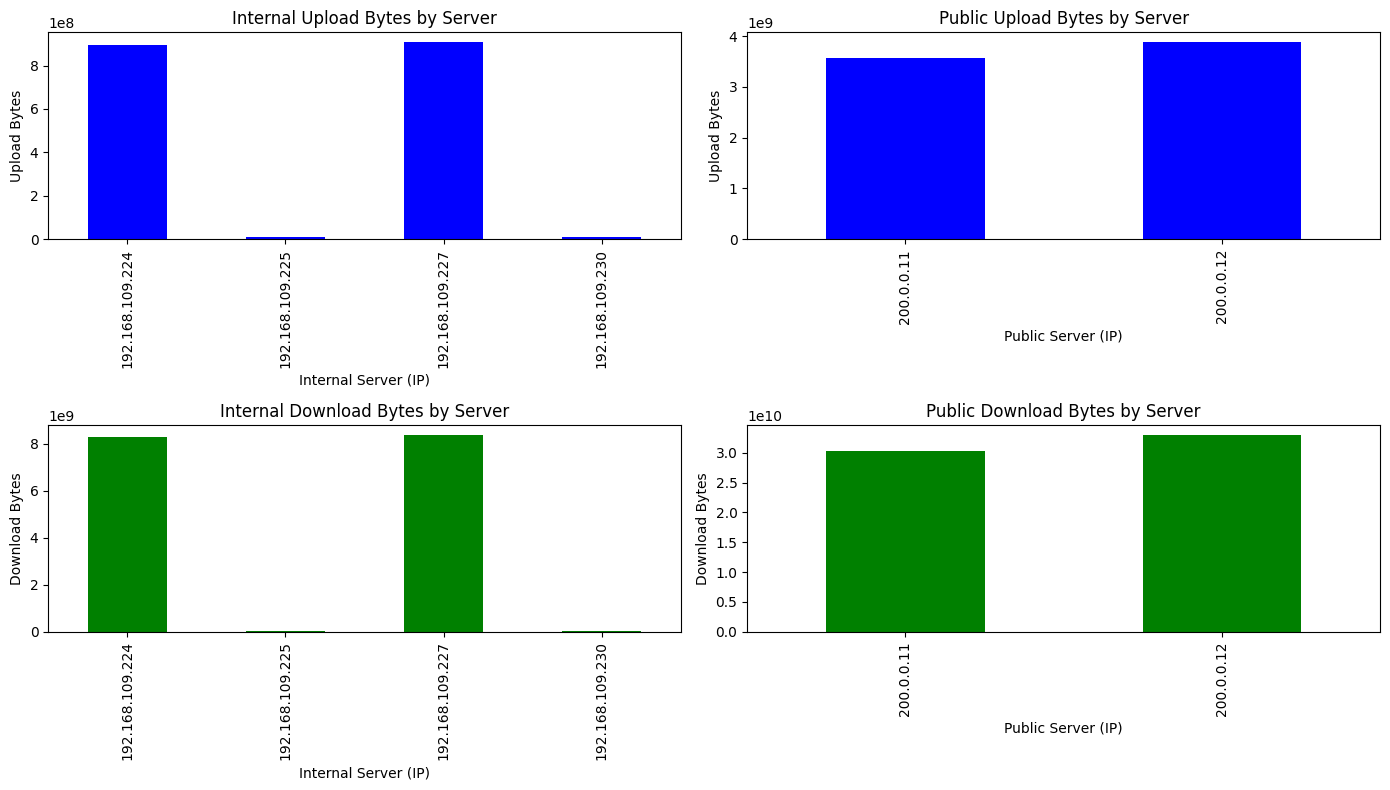

Typical Internal to Internal Traffic Volume (mean):
up_bytes      2.305382e+06
down_bytes    2.109639e+07
dtype: float64
Typical External to Public Server Traffic Volume (mean):
up_bytes      3.762933e+07
down_bytes    3.198378e+08
dtype: float64


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
internal_datafile = './dataset9/data9.parquet'
public_datafile = './dataset9/servers9.parquet'

internal_data = pd.read_parquet(internal_datafile)
public_data = pd.read_parquet(public_datafile)

# Define the internal and public server IP ranges
internal_ip_prefix = '192.168.109.'
public_ip_prefix = '200.0.0.'

# Function to check if an IP is within a specific range
def is_internal(ip):
    return ip.startswith(internal_ip_prefix)

def is_public_server(ip):
    return ip.startswith(public_ip_prefix)

# Classify IPs as internal, external, or public server
internal_data['dst_internal'] = internal_data['dst_ip'].apply(is_internal)
internal_data['src_internal'] = internal_data['src_ip'].apply(is_internal)
public_data['dst_public_server'] = public_data['dst_ip'].apply(is_public_server)

# Internal-to-Internal Traffic
internal_to_internal = internal_data[internal_data['src_internal'] & internal_data['dst_internal']]
traffic_internal = internal_to_internal.groupby(['src_ip', 'dst_ip']).agg({'up_bytes': 'sum', 'down_bytes': 'sum'}).reset_index()
typical_internal = traffic_internal[['up_bytes', 'down_bytes']].mean()

# External-to-Public Traffic
external_to_public = public_data[~public_data['src_ip'].str.startswith(internal_ip_prefix) & public_data['dst_public_server']]
traffic_external_to_public = external_to_public.groupby(['src_ip', 'dst_ip']).agg({'up_bytes': 'sum', 'down_bytes': 'sum'}).reset_index()
typical_external_to_public = traffic_external_to_public[['up_bytes', 'down_bytes']].mean()

# Visualization
plt.figure(figsize=(14, 8))

# Upload bytes comparison
plt.subplot(2, 2, 1)
traffic_internal.groupby('dst_ip')['up_bytes'].sum().plot(kind='bar', color='blue', label='Internal')
plt.title('Internal Upload Bytes by Server')
plt.xlabel('Internal Server (IP)')
plt.ylabel('Upload Bytes')

plt.subplot(2, 2, 2)
traffic_external_to_public.groupby('dst_ip')['up_bytes'].sum().plot(kind='bar', color='blue', label='Public')
plt.title('Public Upload Bytes by Server')
plt.xlabel('Public Server (IP)')
plt.ylabel('Upload Bytes')

# Download bytes comparison
plt.subplot(2, 2, 3)
traffic_internal.groupby('dst_ip')['down_bytes'].sum().plot(kind='bar', color='green', label='Internal')
plt.title('Internal Download Bytes by Server')
plt.xlabel('Internal Server (IP)')
plt.ylabel('Download Bytes')

plt.subplot(2, 2, 4)
traffic_external_to_public.groupby('dst_ip')['down_bytes'].sum().plot(kind='bar', color='green', label='Public')
plt.title('Public Download Bytes by Server')
plt.xlabel('Public Server (IP)')
plt.ylabel('Download Bytes')

plt.tight_layout()
plt.show()

print("Typical Internal to Internal Traffic Volume (mean):")
print(typical_internal)

print("Typical External to Public Server Traffic Volume (mean):")
print(typical_external_to_public)


# Accesses at anusual Times

Access Counts by Hour:
 hour
4        140
5       2936
6       7852
7      20146
8      49156
9      71050
10     91850
11    106289
12    101076
13     92241
14     89858
15     74773
16     63662
17     48070
18     33947
19     24761
20     14844
21      9937
22      3770
23       717
dtype: int64
Unusual Access Times:
 hour
11    106289
dtype: int64


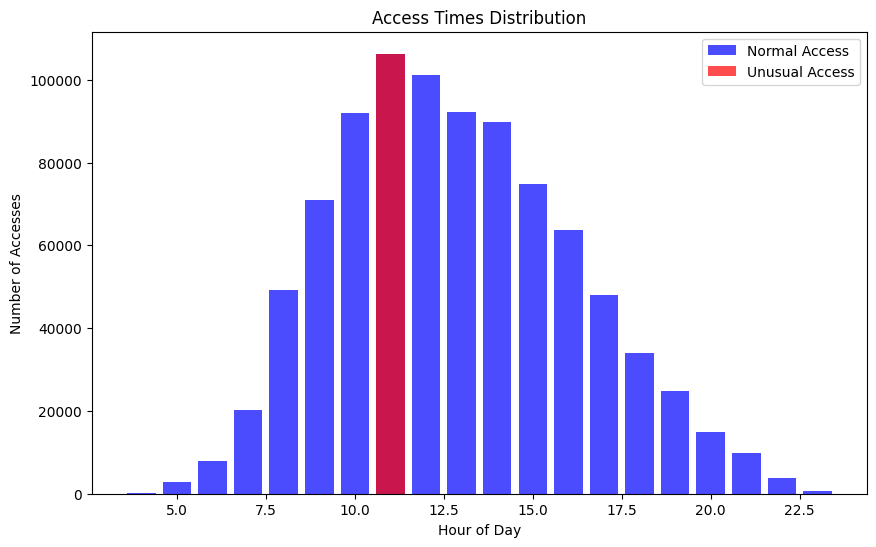

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Preprocess data
data['timestamp'] = (data['timestamp'] / 100).astype(int)
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
data['hour'] = data['datetime'].dt.hour

# Analyze access times
access_counts = data.groupby('hour').size()
print("Access Counts by Hour:\n", access_counts)

# Detect unusual access times
mean = access_counts.mean()
std = access_counts.std()
threshold = 1.5
unusual_times = access_counts[(access_counts > mean + threshold * std) | (access_counts < mean - threshold * std)]
print("Unusual Access Times:\n", unusual_times)

# Plot access times
plt.figure(figsize=(10, 6))
plt.bar(access_counts.index, access_counts.values, color='blue', alpha=0.7, label='Normal Access')
plt.bar(unusual_times.index, unusual_times.values, color='red', alpha=0.7, label='Unusual Access')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accesses')
plt.title('Access Times Distribution')
plt.legend()
plt.show()


# Normal Working Hours

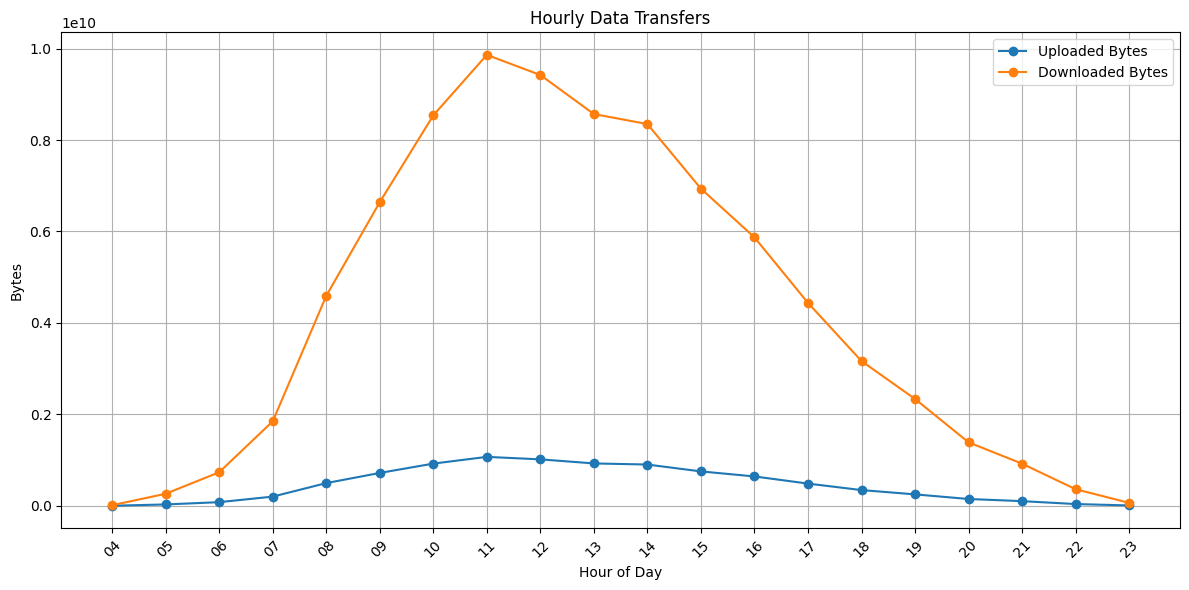

Peak upload hour: 11
Peak download hour: 11


In [42]:
# Max downloads in Working hours

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'timestamp' is in 1/100 of seconds from 0h of the day
data['timestamp'] = pd.to_datetime(data['timestamp'] / 100, unit='s').dt.strftime('%H')

# Group by hour and sum up the uploaded and downloaded bytes
hourly_data = data.groupby('timestamp').agg({'up_bytes': 'sum', 'down_bytes': 'sum'})

# Plot the hourly data transfers
plt.figure(figsize=(12, 6))
plt.plot(hourly_data.index, hourly_data['up_bytes'], label='Uploaded Bytes', marker='o')
plt.plot(hourly_data.index, hourly_data['down_bytes'], label='Downloaded Bytes', marker='o')
plt.title('Hourly Data Transfers')
plt.xlabel('Hour of Day')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Find the hour with the maximum data transfer
max_up_hour = hourly_data['up_bytes'].idxmax()
max_down_hour = hourly_data['down_bytes'].idxmax()
print(f"Peak upload hour: {max_up_hour}")
print(f"Peak download hour: {max_down_hour}")


# Analyze Unusual Protocols

Port Frequency:
 port
443    799199
53     107876
Name: count, dtype: int64


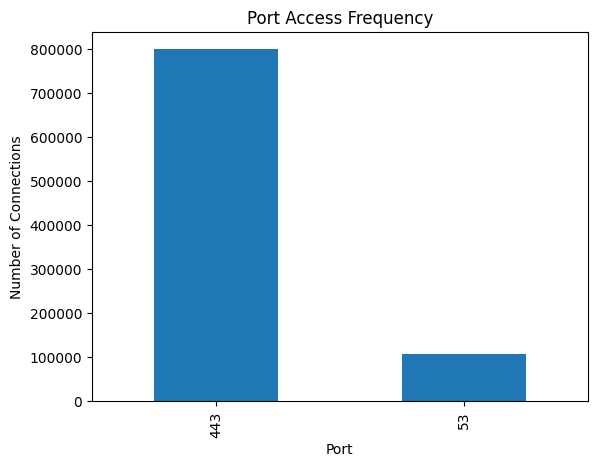

Protocol Frequency:
 proto
tcp    799199
udp    107876
Name: count, dtype: int64


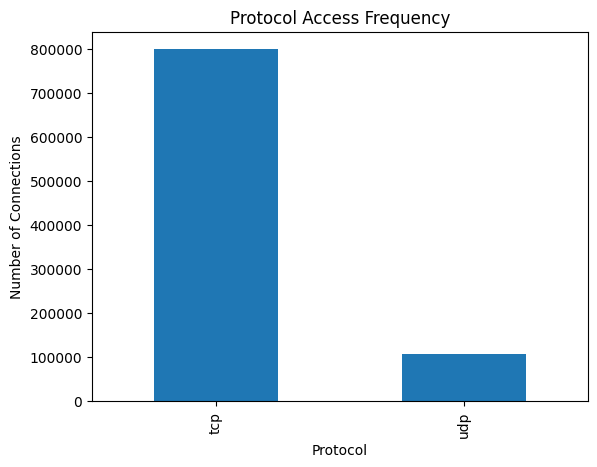

In [51]:
# Frequency analysis for ports
port_frequency = data['port'].value_counts()
print("Port Frequency:\n", port_frequency)

# Plot port frequency
port_frequency.plot(kind='bar')
plt.title('Port Access Frequency')
plt.xlabel('Port')
plt.ylabel('Number of Connections')
plt.show()

# Frequency analysis for protocols
protocol_frequency = data['proto'].value_counts()
print("Protocol Frequency:\n", protocol_frequency)

# Plot protocol frequency
protocol_frequency.plot(kind='bar')
plt.title('Protocol Access Frequency')
plt.xlabel('Protocol')
plt.ylabel('Number of Connections')
plt.show()


# Session Duration

In [60]:
import pandas as pd

# Convert timestamp to datetime
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')

# Calculate session duration
session_duration = data.groupby(['src_ip', 'dst_ip'])['datetime'].agg(['min', 'max'])
session_duration['duration'] = (session_duration['max'] - session_duration['min']).dt.total_seconds()

print("Session Duration:\n", session_duration)

# Identify extremely long or short sessions
short_threshold = session_duration['duration'].quantile(0.05)
long_threshold = session_duration['duration'].quantile(0.95)

short_sessions = session_duration[session_duration['duration'] < short_threshold]
long_sessions = session_duration[session_duration['duration'] > long_threshold]

print("\nShort Sessions:\n", short_sessions)
print("\nLong Sessions:\n", long_sessions)


Session Duration:
                                                min                 max  \
src_ip          dst_ip                                                   
192.168.109.100 104.16.249.130 1970-02-07 14:18:27 1970-02-18 15:37:13   
                104.244.42.129 1970-02-04 17:38:26 1970-03-15 15:02:40   
                104.26.13.207  1970-02-05 12:27:47 1970-02-25 10:19:47   
                104.26.14.51   1970-02-07 17:40:16 1970-02-07 17:51:40   
                104.26.3.211   1970-02-06 21:50:36 1970-03-16 10:27:01   
...                                            ...                 ...   
192.168.109.99  8.25.195.70    1970-02-19 07:35:53 1970-02-19 07:40:45   
                88.157.217.145 1970-02-14 12:09:30 1970-03-05 14:53:27   
                88.157.217.146 1970-02-16 21:57:03 1970-03-05 04:39:34   
                88.157.217.148 1970-02-18 23:25:20 1970-03-05 10:20:30   
                99.83.119.144  1970-02-19 09:41:30 1970-02-19 11:37:00   

                  